Loading data from mounted dataset...
Loaded 94 samples across 3 classes
Training model...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.4236 - loss: 1.3133 - val_accuracy: 0.6000 - val_loss: 0.9461
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5556 - loss: 1.0145 - val_accuracy: 0.8000 - val_loss: 0.6675
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6750 - loss: 0.8135 - val_accuracy: 0.8667 - val_loss: 0.4954
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7833 - loss: 0.5983 - val_accuracy: 0.8667 - val_loss: 0.3897
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8896 - loss: 0.4259 - val_accuracy: 0.8667 - val_loss: 0.3244
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9667 - loss: 0.2885 - val_accuracy: 0.8667 - val_loss: 0.2827
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8597 - loss: 0.3734 - val_accuracy: 0.8667 - val_loss: 0.2502
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━

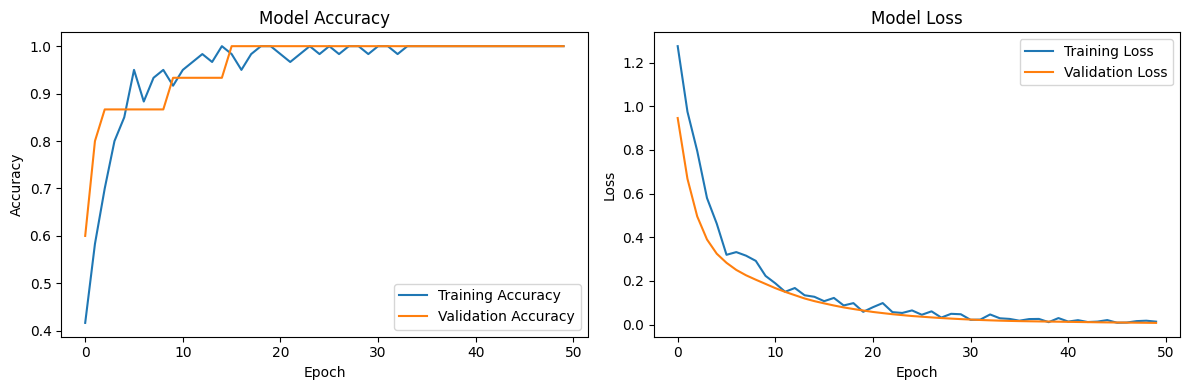

Model saved to wand_model.h5


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from azureml.core import Workspace, Dataset, Run

# Define constants
GESTURE_CLASSES = ["O", "V", "Z"] # Adjust based on your data
SEQUENCE_LENGTH = 100  # Adjust based on your data
MODEL_SAVE_PATH = "wand_model.h5"

def load_data_from_directory(directory):
    """Load gesture sequences from CSV files organized in subdirectories by class."""
    features = []
    labels = []

    for idx, class_name in enumerate(GESTURE_CLASSES):
        class_dir = os.path.join(directory, class_name)

        if not os.path.isdir(class_dir):
            print(f"Skipping missing class directory: {class_dir}")
            continue

        for file_name in os.listdir(class_dir):
            if file_name.endswith('.csv'):
                file_path = os.path.join(class_dir, file_name)

                try:
                    df = pd.read_csv(file_path)
                    if not {'x', 'y', 'z'}.issubset(df.columns):
                        print(f"Skipping malformed CSV (missing columns): {file_name}")
                        continue

                    sequence = df[['x', 'y', 'z']].values.tolist()

                    if len(sequence) >= SEQUENCE_LENGTH:
                        features.append(sequence[:SEQUENCE_LENGTH])
                        labels.append(idx)
                    elif len(sequence) > 10:  # ignore very short sequences
                        padded = sequence + [[0, 0, 0]] * (SEQUENCE_LENGTH - len(sequence))
                        features.append(padded)
                        labels.append(idx)

                except Exception as e:
                    print(f"Error reading {file_name}: {e}")

    return np.array(features), np.array(labels)


def preprocess_data(features, labels):
    """Preprocess the data: reshape, normalize, and split into train/test sets."""
    n_samples = features.shape[0]
    features_flat = features.reshape(n_samples, -1)

    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features_flat)

    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, labels, test_size=0.2, random_state=42, stratify=labels
    )

    return X_train, X_test, y_train, y_test

def build_model(input_shape, num_classes):
    """Build a neural network model for gesture classification."""
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    # Detect if we're running in AzureML job context or not
    run = Run.get_context()

    if hasattr(run, "experiment"):
        # We're in an AzureML job
        ws = run.experiment.workspace
    else:
        # We're running locally (e.g., in JupyterLab)
        ws = Workspace.from_config()  # assumes config.json is present or you're in a bound environment

    # Proceed as normal with dataset
    dataset = Dataset.File.from_files(path=(ws.get_default_datastore(), 'UI/2025-06-06_034231_UTC/data/**')) # Find the relative path in your own datastore

    mount_context = dataset.mount("data")
    mount_context.start()

    try:
        print("Loading data from mounted dataset...")
        features, labels = load_data_from_directory("data")

        if len(features) == 0:
            print("No data found. Please check your data directory.")
            return

        print(f"Loaded {len(features)} samples across {len(GESTURE_CLASSES)} classes")

        X_train, X_test, y_train, y_test = preprocess_data(features, labels)
        input_shape = X_train.shape[1]
        model = build_model(input_shape, len(GESTURE_CLASSES))

        print("Training model...")
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True
                )
            ]
        )

        print("Evaluating model...")
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f"Test accuracy: {test_acc:.4f}")

        run.log("Test Accuracy", test_acc)
        run.log("Test Loss", test_loss)

        plot_training_history(history)
        model.save(MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH}")

    finally:
        mount_context.stop()

if __name__ == "__main__":
    main()
